In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [19]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import unified_loss
from tools.score_net import score_model_mlp
from tools.sampling import ddpm_sampler,ddim_sampler,annealed_langevin_dynamic_sampler
from tools.utils import plot_gradient

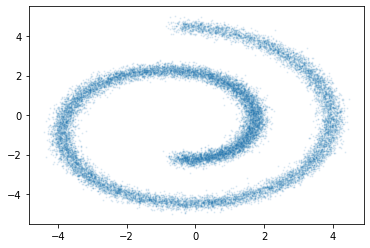

In [3]:
from sklearn.datasets import make_swiss_roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
# data = sample_batch(10**4)

data = make_swiss_roll(n_samples = 2*10**4,noise=0.5)[0][:,[0,2]]
data = (data - data.min()) / (data.max() - data.min())
data = data * 10 - 5

#normalize data
# data_mean = data.mean(0)
# data_std = data.std(0)
# data = (data - data_mean) / data_std


# def inverse_normalize(data):
#     return data * data_std + data_mean

# target = nf.distributions.TwoMoons()
# data = target.sample(100000)
# plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

# import os
# obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'
# data=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)
# #select data with x<0
# data=data[data[:,0]<0]
# #increase data number by adding small noise
# data_new=data+np.random.normal(0,0.01,data.shape)
# data=np.concatenate([data,data_new],axis=0)

plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

In [4]:
ns=noise_scheduler(1e-4,2e-2,100,schedule='linear',var_norm=True)

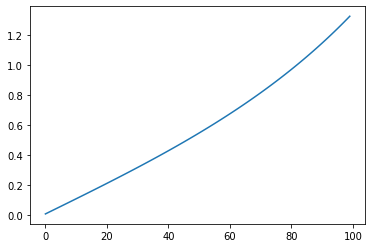

In [5]:
ns.plot_marginal_std()

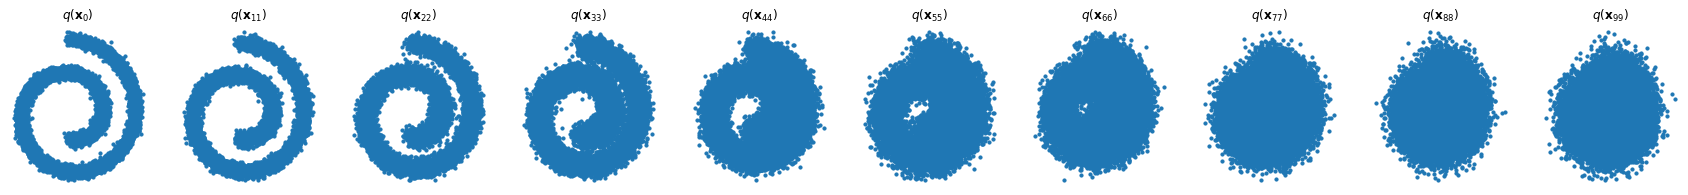

In [6]:
ns.visualize_noise(torch.tensor(data))

In [7]:
model = score_model_mlp(input_dim=2,n_steps=100,hidden=[256,512,512]).to(device)
# model = score_model_mlp(x_dim=2,n_steps=100,hidden_dim=[256,512,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [8]:
dataset=torch.tensor(data).float().to(device)
epochs = 1000
batch_size = 20000
for epoch in range(epochs):

    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = unified_loss(model, batch_x, t,ns)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


1.0108486413955688
0.7696925401687622
0.7398024201393127
0.7420807480812073
0.7519894242286682
0.7399370670318604
0.7311844825744629
0.730944037437439
0.7347300052642822
0.7390910983085632


In [9]:
sampler=ddpm_sampler(model,ns,device=device)

In [10]:
x_seq=sampler.loop_sample(dataset.shape)

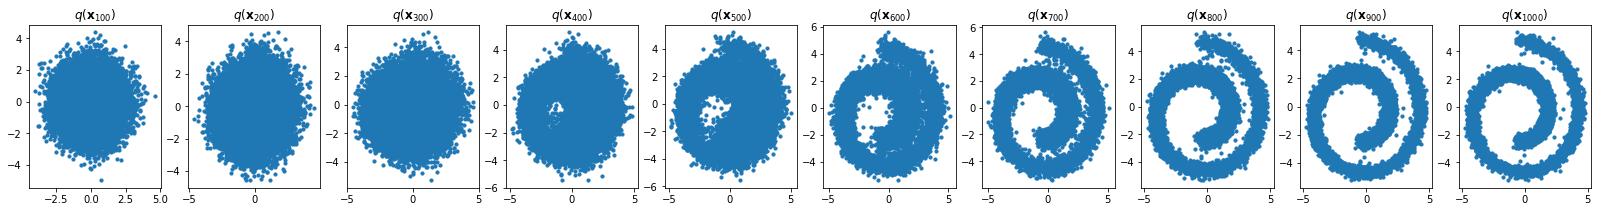

In [11]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i*10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

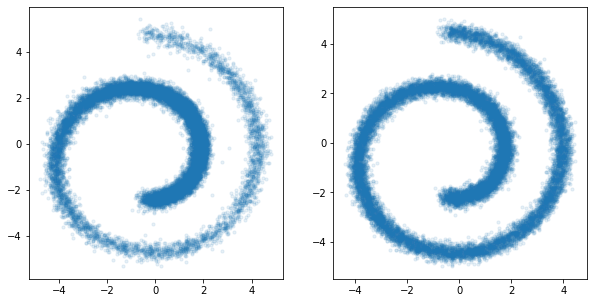

In [12]:
final=(x_seq[-1].detach().cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*final.T , s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*data.T, s=10, alpha=0.1)


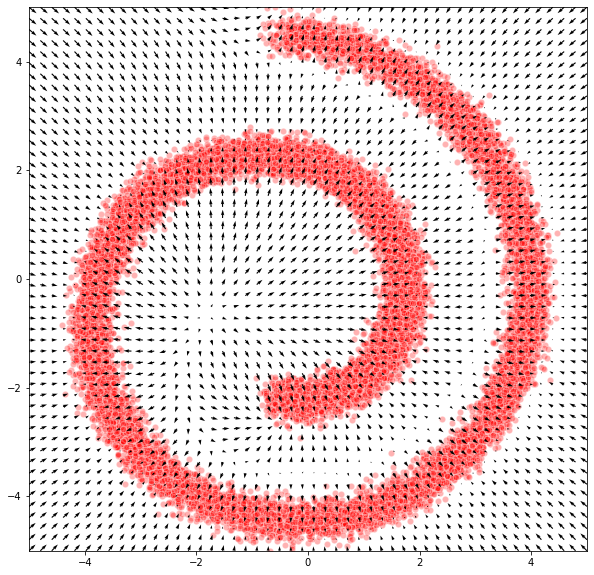

In [18]:
plot_gradient(model,(-5,5),(-5,5),n=50,t=0)

In [20]:
from tools.sampling import ddim_sampler

In [21]:
sampler_20x=ddim_sampler(model, ns, eta=0,tau=20, device='cuda', scheduling = 'uniform')
sampler_1x=ddim_sampler(model, ns, eta=1,tau=1, device='cuda', scheduling = 'uniform')

In [22]:
%%timeit
x_seq_ddpm=sampler_1x.loop_sample(data.shape)

213 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
x_seq_ddim=sampler_20x.loop_sample(data.shape)

10.8 ms ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
x_seq_ddpm=sampler_1x.loop_sample(data.shape)
x_seq_ddim=sampler_20x.loop_sample(data.shape)

Text(0.5, 1.0, 'Real Data')

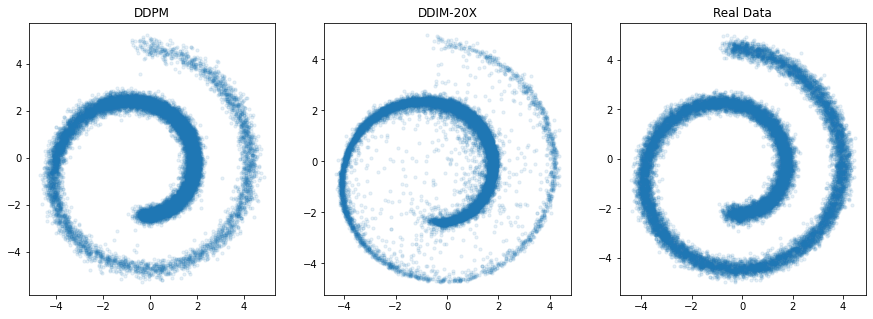

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(*x_seq_ddpm[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDPM')

plt.subplot(1, 3, 2)
plt.scatter(*x_seq_ddim[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDIM-20X')

plt.subplot(1, 3, 3)
plt.scatter(*data.T, s=10, alpha=0.1)
plt.title('Real Data')


NCSN

In [26]:
# ns=noise_scheduler(1e-5,2e-2,10,schedule='sigmoid',var_norm=False)

ns=noise_scheduler(1e-4,2e-2,100,schedule='linear',var_norm=False)

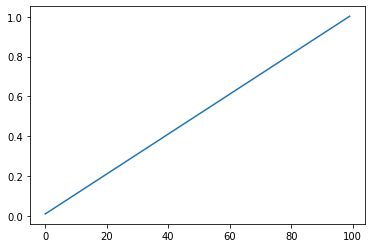

In [27]:
ns.plot_marginal_std()

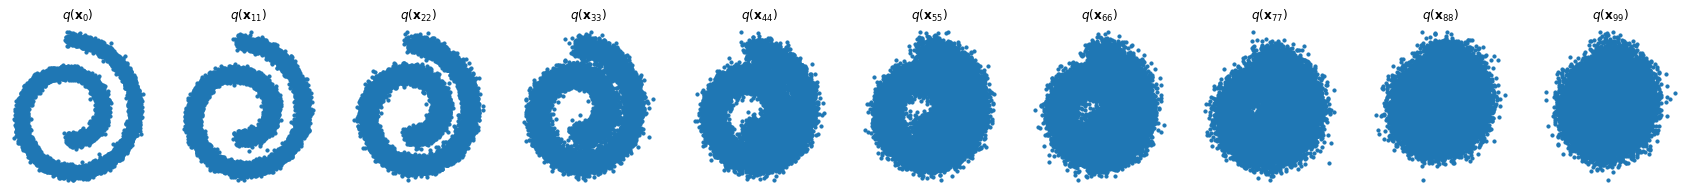

In [28]:
ns.visualize_noise(torch.tensor(data))

In [31]:
model = score_model_mlp(input_dim=2,n_steps=100,hidden=[256,512,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [32]:
dataset=torch.tensor(data).float().to(device)
epochs = 1000
batch_size = 20000
for epoch in range(epochs):

    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = unified_loss(model, batch_x, t,ns)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


1.0034490823745728
0.7661243677139282
0.7455155849456787
0.7418888211250305
0.7399170994758606
0.7343335747718811
0.7225914597511292
0.735978901386261
0.737415611743927
0.7331143617630005


In [33]:
sampler=annealed_langevin_dynamic_sampler(model,ns,100,device=device,eps=1e-5)

In [34]:
x_seq=sampler.loop_sample(dataset.shape)

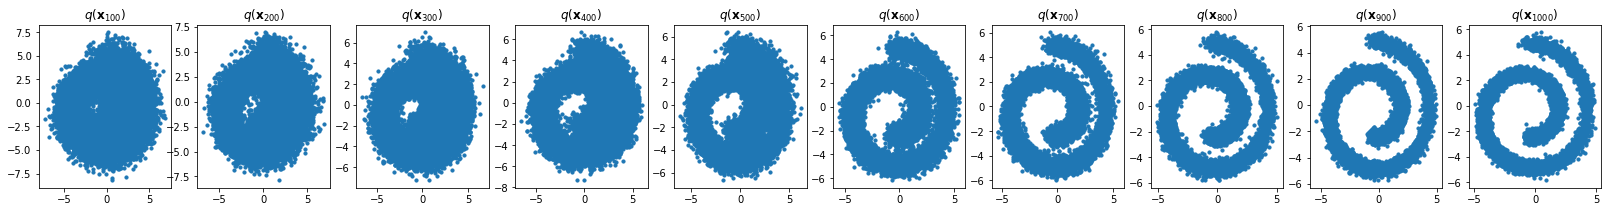

In [35]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i*10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

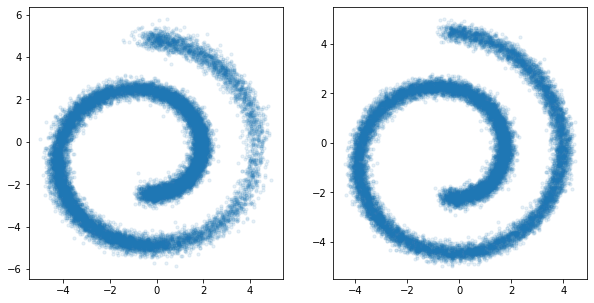

In [36]:
final=(x_seq[-1].detach().cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*final.T , s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*data.T, s=10, alpha=0.1)


In [38]:
def plot_gradient(score_fn,xrange,yrange,n=20,t=0,device='cuda',ref_data=None):
    x = np.linspace(*xrange, n)
    y = np.linspace(*yrange, n)
    x, y = np.meshgrid(x, y)
    z = np.stack([x, y], axis=-1)
    z = torch.tensor(z, dtype=torch.float32).view(-1, 2).to(device)
    labels = torch.ones(z.shape[0]).long().to(device)*t
    with torch.no_grad():
        scores = score_fn(z, labels).detach().cpu().numpy()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

    plt.figure(figsize=(10,10))
    if ref_data is not None:
        plt.scatter(*ref_data.T, alpha=0.3, color='red', edgecolor='white', s=40)
    plt.quiver(*z.cpu().T, *scores_log1p.T, width=0.002, color='black')
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()

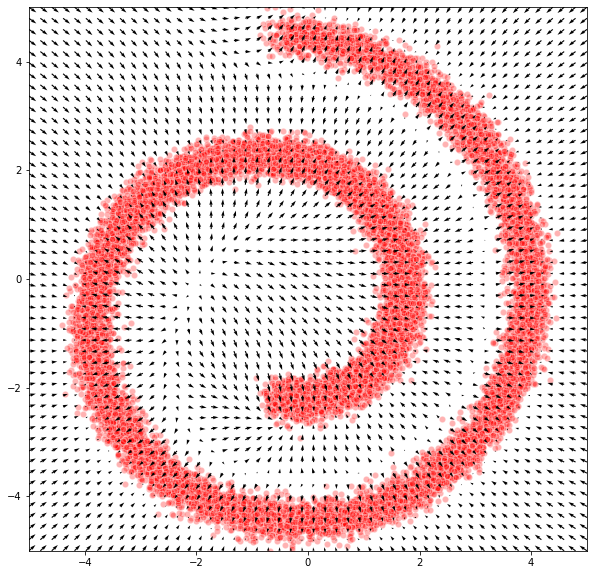

In [40]:
plot_gradient(model,(-5,5),(-5,5),n=50,t=0,ref_data=data)